In [18]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.signal as signal
from mosqito.utils.time_segmentation import time_segmentation

import torchaudio
import torch
import torch.nn.functional
import librosa


input_array, sr = librosa.load('ex/#05_SX2_B_ES_LH_1_3_Mic_30cm_S.wav', sr=12800, mono=True)


nperseg = 2046 # fs = 12800Hz 기준 Δt = 0.16s(Δf = 6.25Hz)
noverlap = 1536 # hop size(noverlap = TL time increment)

P_ref = 20e-6


sig, _ = time_segmentation(
        input_array, sr, nperseg=nperseg, noverlap=noverlap, is_ecma=False
    )
# print(sig.shape)
sig = torch.from_numpy(sig)


nfft = sig.shape[0]
nseg = sig.shape[1]
window = np.hanning(nfft)
window = np.tile(window,(nseg,1)).T
# spec = 1 / np.mean(window[:,0]) * fft(sig * window, n=nfft, axis=0)/nperseg
spec = fft(sig, n=nfft, axis=0)[0:nfft//2]
spec_abs = 2*abs(spec)/nfft

spec_abs = 20 * (np.log10(spec_abs*50000)) # 진동데이터는 50000 대신 10**6

print(spec_abs.shape)
print(spec_abs.max())

(1023, 135)
64.46754160595381


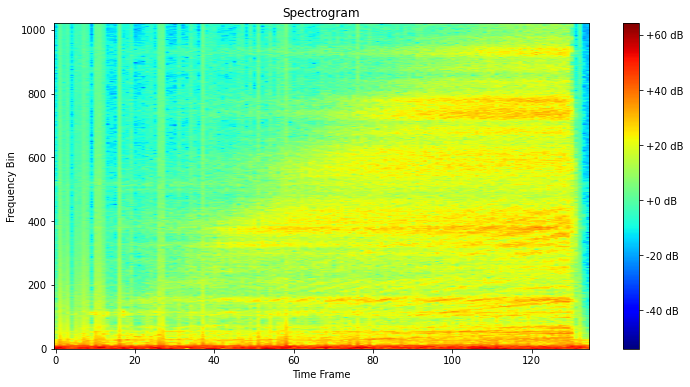

In [19]:
plt.figure(figsize=(12, 6))
plt.imshow(spec_abs, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.show()

In [20]:
stft_result = torch.from_numpy(spec_abs)

n_fft = (stft_result.size(0) - 1) * 2
    
# print(stft_result)    

# 주파수 bins 계산
freqs = np.linspace(0, 12800 / 2, stft_result.size(0))
    
# A-weighting dB 값 계산
a_weighting_db = librosa.A_weighting(freqs)
    
# 텐서로 변환
a_weighting_scale_tensor = torch.from_numpy(a_weighting_db)
#     print(torch.abs(a_weighting_scale_tensor).log10().unsqueeze(1).shape)
    
# A-weighted STFT 계산
a_weighted_stft = stft_result + a_weighting_scale_tensor.unsqueeze(1)


In [21]:
a_weighted_stft = a_weighted_stft.T
a_weighted_stft = torch.where(a_weighted_stft < 0, 0, a_weighted_stft)

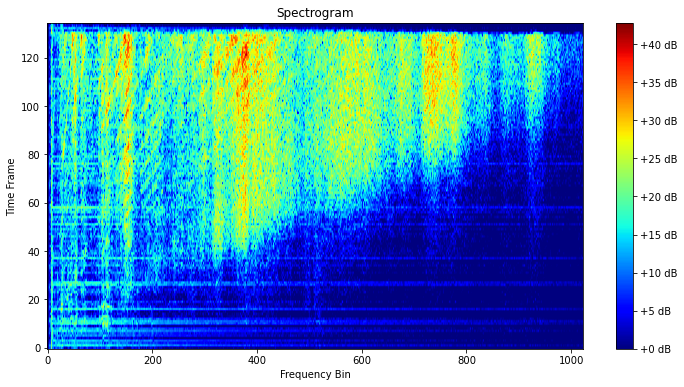

In [22]:
plt.figure(figsize=(12, 6))
plt.imshow(a_weighted_stft, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Frequency Bin')
plt.ylabel('Time Frame')
plt.show()

In [27]:
a_weighted_stft.max()

tensor(42.8131, dtype=torch.float64)